# TV brand 2016 - Twitter Data Analysis



### Learning goals:
1. Determine the countries with the highest number of tweets (based on the user profile information).

2. Analyze tweet sentiments

3. Draw insights from tweets about major tv manufacturers world wide by combining Twitter timeline analysis with sentiment, determining gender distribution and location distribution.

4. Draw insights about attractive tv features across TV makers.


### Preparing the data set and data flow
#### Data source
The first step in the analysis process is to harvest the twitter data. In this sample, we use the DashDB connector to the IBM Insights for Twitter service to seamlessly specify a filter query and load the results into DashDB. A query is used to filter the tweets and return only those that were posted about 6 leading manufacturers in 2016.


### Analyzing tweets

In this notebook sample, you will use SparkContext which enables you to run tasks on the Spark cluster. Using Spark in notebooks enables you to analyze large amounts of data very efficiently. The sample begins with basic analysis steps which slowly progress into deeper analytic work. 
In this Notebook, we will analyze the loaded data to extract interesting insights and plots from it. This analysis is performed using SparkContext which enables us to run tasks on spark cluster. Using spark and notebooks is a very strong combination. It enables you to analyze big amount of data very efficiently. We will start with some basic analysis then go deeper gradually.


##### Notebook structure
1. Importing libraries
2. Defining global variables and helper functions
3. Acquiring the data
4. Transforming the data
5. Determining the distribution of tweets across geographies
6. Analyzing tweet sentiments
7. Analyzing Twitter timelines
8. Drawing insights from tweets about elc manufacturers
9. Drawing insights about elc features
10. Summary

# 1. Importing libraries
Run the following cell to install the needed libraries you will work with in the sample.
install the Natural language toolkits - cell 1 and 2

In [1]:
!pip install nltk --user

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/s6b0
[nltk_data]     -5338fa1d5b340e-a8c958926765/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Import Python modules and set up the SQLContext, by running the commands in the cell 
# define global variables

from pyspark.sql import SQLContext
from pyspark.sql import functions as F

import time
from datetime import date
from dateutil import parser

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np

from IPython.core.display import Javascript

from __future__ import division

%matplotlib inline

sqlContext = SQLContext(sc)

# 2. Defining global variables and helper functions

In this sample, you will use the variables:
- elc_marker_list which contains all tv manifacturers. Each element in the array is a list with all spelling variants of each manufacturer.
- list elc_makers_name_list which contains the most common spelling variant of each elc manufacturer.

In [4]:
# set up various data structures
elc_makers_list = [['samsung'], ['lg', 'sanyo'], ['toshiba'], ['philips'], ['panasonic']]

elc_makers_name_list = []
for elc_maker in elc_makers_list:
    elc_makers_name_list.append(elc_maker[0].upper())

#plotting variables
ind = np.arange(len(elc_makers_list)) #index list for plotting
width = 0.8       # the width of the bars in the bar plots

num_elc_makers = len(elc_makers_list)


SCHEMA="DASH13114."
PREFIX="EBRAND_"


The sample uses the helper function called GeoChart to plot the world map in a DOM element (an iframe).
The helper function addMissingDates checks for any missing dates in DataFrames with time series data.
* baseDataframe: this DataFrame contains all dates. It must have the column names [POSTING_TIME, NUM_TWEETS]
* checkedDataframe: this DataFrame contains the dates that need to be checked. It must have the column names [POSTING_TIME, NUM_TWEETS]

In [5]:
#set up some global helper functions for google maps and missing dates.
def GeoChart(data_string, element):
    return Javascript("""
        //container.show();
        function draw() {{
          var chart = new google.visualization.GeoChart(document.getElementById(""" + element + """));
          chart.draw(google.visualization.arrayToDataTable(""" + data_string + """));
        }}
        google.load('visualization', '1.0', {'callback': draw, 'packages':['geochart']});
        """, lib="https://www.google.com/jsapi")

def addMissingDates(baseDates, checkedDates):
    temp = checkedDates.copy()
    checkedDatesValues = checkedDates['POSTING_TIME']
    for index, row in baseDates.iterrows():
        if (not row['POSTING_TIME'] in checkedDatesValues.tolist()):
            row['NUM_TWEETS'] = 0
            temp = temp.append(row)
    return temp.sort('POSTING_TIME')

# 3. Acquiring data

To access the data in dashDB, you must provide the dashDB service credentials. The data is retrieved from the database by using the Spark JDBC connector and is loaded into a Spark DataFrame in the notebook called df_elcS_TWEETS using sqlContext.read.jdbc. The dataframe has the same column names as the tweets table in dashDB.
Run the next cell to use the credentials provided with this sample or adjust the credentials if you want to use your oun dashDB instance.

#### Note: The data is only allowed to be used in the context of the current sample.

The code in the next cell reads the credentials and loads the data from dashBD into a DataFrame data structure.

In [6]:
# Acquire the data from dashDB.
# Enter the credentials you copied from your dashDB connections page.

Enter the credentials you copied from your dashDB connections page.
props = {}
props['user'] = 'dash13114'
props['password'] = 'Kgbu@@g68OPE'
jdbcurl='jdbc:db2://dashdb-entry-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB'

#get the data frame
df_TWEETS = sqlContext.read.jdbc(jdbcurl, SCHEMA + PREFIX +'TWEETS', properties=props)
df_TWEETS.printSchema()

df_SENTIMENTS = sqlContext.read.jdbc(jdbcurl, SCHEMA + PREFIX + 'SENTIMENTS', properties=props)
df_SENTIMENTS.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_DISPLAY_NAME: string (nullable = true)
 |-- USER_FAVORITES_COUNT: integer (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = tru

The following code cell counts the number of rows which were loaded into the DataFrame which is equivalent to the number of tweets available for further processing.

In [7]:
# Assign sentiment score to each tweet.
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
udf = UserDefinedFunction(lambda x: 0 if x=='AMBIVALENT' else 1 if x=='POSITIVE' else -1, IntegerType())
udf2 = UserDefinedFunction(lambda x: 'POSITIVE' if x>0 else 'NEGATIVE' if x<0 else 'AMBIVALENT', StringType())

%time df=df_TWEETS.join(df_SENTIMENTS, "MESSAGE_ID")
%time df=df.withColumn('SENTIMENT_POLARITY', udf(df.SENTIMENT_POLARITY) ).groupBy('MESSAGE_ID').agg(F.mean('SENTIMENT_POLARITY').alias("SENTIMENT_POLARITY"))
%time df=df.withColumn('SENTIMENT', udf2(df.SENTIMENT_POLARITY))
%time df_JOIN_TWEETS=df_TWEETS.join(df, "MESSAGE_ID")
%time df_JOIN_TWEETS.printSchema()
%time df_JOIN_TWEETS.count()

CPU times: user 241 µs, sys: 737 µs, total: 978 µs
Wall time: 130 ms
CPU times: user 6.18 ms, sys: 4.26 ms, total: 10.4 ms
Wall time: 253 ms
CPU times: user 1.1 ms, sys: 326 µs, total: 1.43 ms
Wall time: 13 ms
CPU times: user 968 µs, sys: 0 ns, total: 968 µs
Wall time: 126 ms
root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USE

519

# 4. Transforming the data


You can't analyze the data that you have just loaded into the data frames the way it is. You must first mung the data.

The output of the data transformation process is a new Spark DataFrame which has the target structure on which to base the data analysis. This Spark DataFrame called df_cleaned_tweets functions as the main data source for all further processing.

Run the next cell to elcry out the following transformations on the data:

1) Remove the time from the timestamp values as only the date information is relevant.

2) Change the values in the string columns like user country, state and city to upper case.

3) Change the tweet posting location information from a string ('pos (42.000 42.000)') to a numeric value represented by the longitude and latitude coordinates. 


You will use the resulting dataframe (df_cleaned_tweets) as the base data source for all further step. The sample uses Spark to do all heavy computation. When it is time to plot or collect the results, the returned data is copied into the kernel memory, in other words moved from a Spark DataFrame to a pandas DataFrame.</font>

In [8]:
# to create a clean working data frame that will be easier to analyze.
def getLongitudeLatitude(position):
    parts = str(position).split('(')[1].split(')')[0].split(' ')
    return parts

def getLongitude(row):
    if (row.MESSAGE_LOCATION is None):
        return None
    else:
        try:
            parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
            lon = float(parts[0])
            return lon
        except:
            return None

def getLatitude(row):
    if (row.MESSAGE_LOCATION is None):
        return None
    else:
        try:
            parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
            lon = float(parts[1])
            return lon
        except:
            return None

def getDateIgnoreTime(row):
    posting_time = parser.parse(str(row.MESSAGE_POSTED_TIME))
    posting_time = posting_time.replace(hour=0, minute=0, second=0, microsecond=0)
    return posting_time

#Mung Data
schema=StructType([
        StructField('MESSAGE_ID',StringType()),
        StructField('POSTING_TIME',TimestampType()),
        StructField('MESSAGE_BODY',StringType()),
        StructField('USER_GENDER',StringType()),
        StructField('USER_STATE',StringType()),
        StructField('USER_COUNTRY',StringType()),
        StructField('USER_CITY',StringType()),
        StructField('MESSAGE_LANGUAGE',StringType()),
        StructField('MESSAGE_LOCATION_LONGITUDE',FloatType()),
        StructField('MESSAGE_LOCATION_LATITUDE',FloatType()),
        StructField('SENTIMENT',StringType()),
        StructField('USER_FOLLOWERS_COUNT',IntegerType()),
        StructField('USER_FRIENDS_COUNT',IntegerType())
    ])
df_cleaned_tweets = sqlContext.createDataFrame(df_JOIN_TWEETS.map(lambda row: [row.MESSAGE_ID,
                        getDateIgnoreTime(row),
                        row.MESSAGE_BODY,
                        row.USER_GENDER,
                        unicode(row.USER_STATE).upper(),
                        unicode(row.USER_COUNTRY).upper(),
                        unicode(row.USER_CITY).upper(),
                        row.MESSAGE_LANGUAGE,
                        getLongitude(row),
                        getLatitude(row),
                        row.SENTIMENT,
                        row.USER_FOLLOWERS_COUNT,
                        row.USER_FRIENDS_COUNT
                    ]), schema)

df_cleaned_tweets.registerTempTable('TV BRAND 2016_TWEETS_CLEANED')
df_cleaned_tweets.cache()
df_cleaned_tweets.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_STATE: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- USER_CITY: string (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_LOCATION_LONGITUDE: float (nullable = true)
 |-- MESSAGE_LOCATION_LATITUDE: float (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = true)



# 5. Determining the distribution of tweets across geographies

This section shows you how to extract the countries, which have the highest number of tweets. To do that the data is grouped according to the USER_COUNTRY column and the rows in each group are counted. Then the groups are sorted in descending order.


In [9]:
%time print("Number of Tweets: " + str(df_TWEETS.count()))
%time print("Number of Sentiment Records: " + str(df_SENTIMENTS.count()))

Number of Tweets: 519
CPU times: user 7.25 ms, sys: 0 ns, total: 7.25 ms
Wall time: 2.63 s
Number of Sentiment Records: 669
CPU times: user 5.86 ms, sys: 0 ns, total: 5.86 ms
Wall time: 226 ms


In [10]:
#group by country
df_cleaned_tweets_countries = df_cleaned_tweets.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                                .orderBy('NUM_TWEETS', ascending=False)

df_cleaned_tweets_countries.cache()
df_cleaned_tweets_countries.show(5)

+--------------------+----------+
|        USER_COUNTRY|NUM_TWEETS|
+--------------------+----------+
|       UNITED STATES|       258|
|                NONE|        84|
|      UNITED KINGDOM|        80|
|VENEZUELA (BOLIVA...|        26|
|               CHILE|        18|
+--------------------+----------+
only showing top 5 rows



In [11]:
# convert Spark SQL dataframe to Pandas data structure for visualization.
p_df_cleaned_tweets_countries = df_cleaned_tweets_countries.toPandas()
p_df_cleaned_tweets_countries.ix[p_df_cleaned_tweets_countries['USER_COUNTRY'] == 'NONE', 'USER_COUNTRY'] = 'UNKNOWN'

The next cells show you two ways of plotting the countries with the largest number of tweets. As this data needs no further munging, the data is copied into a pandas DataFrame which is used for plotting the results.

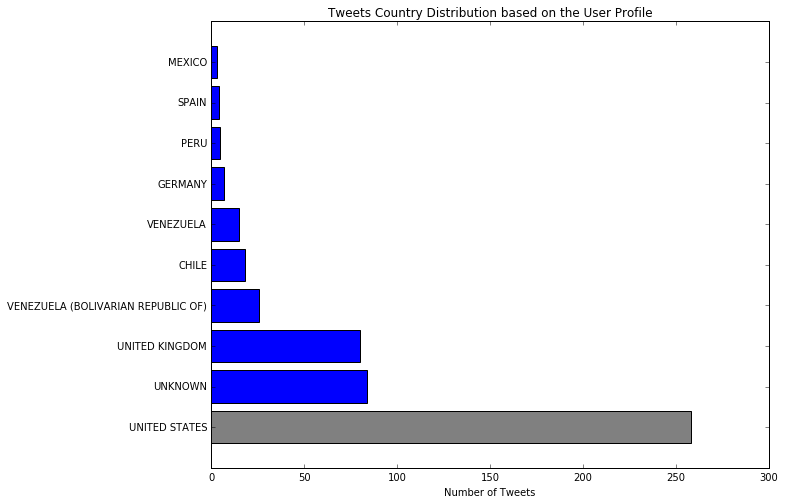

In [12]:
#To see the geographic tweet distribution in a bar chart,
num_plotted_countries = 10

countries = p_df_cleaned_tweets_countries['USER_COUNTRY'][:num_plotted_countries]
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS'][:num_plotted_countries]
y_pos = np.arange(len(countries))
colors = np.repeat('b', num_plotted_countries - 1).tolist()
colors = ['gray'] + colors

plt.figure(figsize=(10,8))
plt.barh(y_pos, num_tweets, align='center', color=colors)
plt.yticks(y_pos, countries)
plt.xlabel('Number of Tweets')
plt.title('Tweets Country Distribution based on the User Profile')
plt.ylim(-1, len(y_pos))

plt.show()


%%html
<div id="plot_div" style="width: 900px; height: 500px;"></div>

In [13]:

countries = p_df_cleaned_tweets_countries['USER_COUNTRY']
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS']

data = "[['Country', 'Num Tweets']"
index = 0
for country in countries:
    country = country.replace("'", "")
    data = data + ", ['" + country + "', " + str(num_tweets[index]) + "]"
    index += 1
data = data + "]"

GeoChart(data, "'plot_div'")

<IPython.core.display.Javascript object>

As you won't need the data frames related to countries any longer run the following cell to clear the memory of those variables (both Spark and pandas).

In [14]:
# Clean up memory
df_cleaned_tweets_countries.unpersist()
df_cleaned_tweets_countries = None
p_df_cleaned_tweets_countries = None

# 6. Analyzing tweet sentiments

Sentiment analysis is one of the most valuable sources of information that the IBM twitter API provides. By giving each tweet a sentiment value, you can determine whether the content of a tweet is positive, negative, ambivalent, neutral, or NULL, if no value is provided by the API. Unfortunately, a sentiment value is provided for English, German, French, and Spanish tweets only. As the data set also has tweets in other languages, only a sub set of the tweets in the data set have a sentiment value.

The cells in the following section show you how to plot the sentiment values of all tweets in the data set. This is done by grouping tweets according to their sentiment value and then counting the number of tweets in each group.

After you have plotted the results, run the cell to release the memory of the variables you used.

In [15]:
#get number of tweets with P N U sentiment by grouping the sentiment value
tweets_grouped_by_sentiment = df_cleaned_tweets\
                .groupBy('SENTIMENT')\
                .agg(F.count('MESSAGE_ID').alias('NUM_TWEETS'))

tweets_grouped_by_sentiment.cache()
tweets_grouped_by_sentiment.show(5)

#move the results to pandas
p_tweets_grouped_by_sentiment = tweets_grouped_by_sentiment.toPandas()

+----------+----------+
| SENTIMENT|NUM_TWEETS|
+----------+----------+
|AMBIVALENT|        15|
|  POSITIVE|       381|
|  NEGATIVE|       123|
+----------+----------+



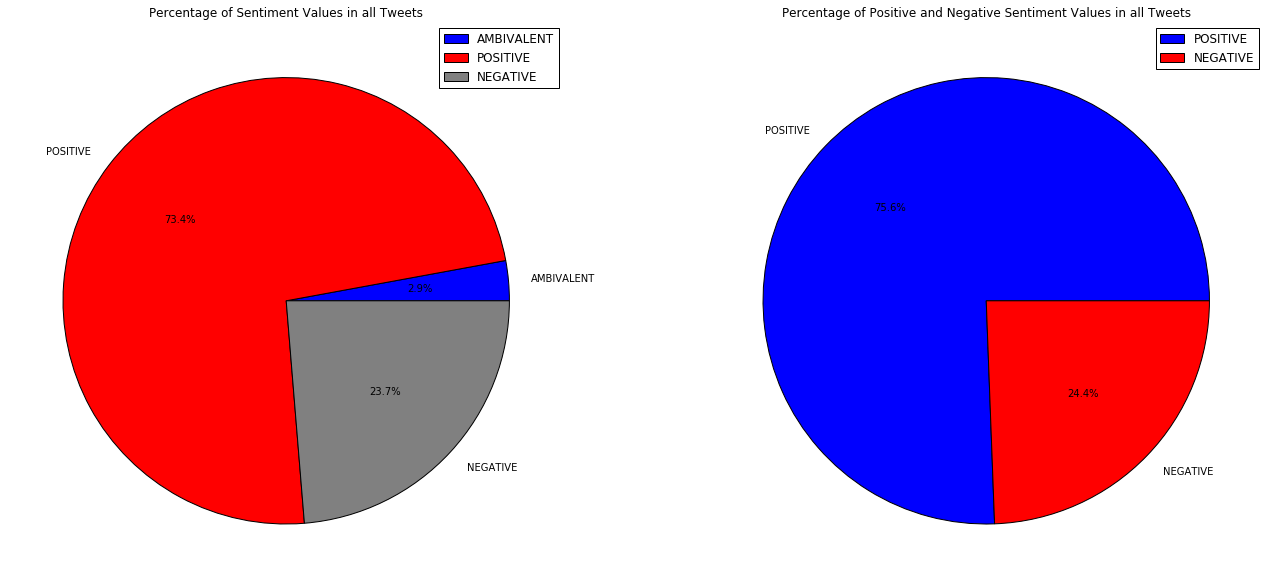

In [16]:
# Visualize with a Matplot pie chart
#data plot 1
plot1_labels = p_tweets_grouped_by_sentiment['SENTIMENT']
plot1_values = p_tweets_grouped_by_sentiment['NUM_TWEETS']
plot1_colors = ['blue', 'red', 'gray', 'yellow', 'green']

#data plot 2
cond1 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'POSITIVE')
cond2 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'NEGATIVE')

pMessage_sentiment_statistics_defined = p_tweets_grouped_by_sentiment[cond1 | cond2]
plot2_labels = pMessage_sentiment_statistics_defined['SENTIMENT']
plot2_values = pMessage_sentiment_statistics_defined['NUM_TWEETS']
plot2_colors = ['blue', 'red']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

axes[0].pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
axes[0].set_title('Percentage of Sentiment Values in all Tweets')
axes[0].set_aspect('equal')
axes[0].legend(loc="upper right", labels=plot1_labels)

# Plot
axes[1].pie(plot2_values,  labels=plot2_labels, colors=plot2_colors, autopct='%1.1f%%')
axes[1].set_title('Percentage of Positive and Negative Sentiment Values in all Tweets')
axes[1].set_aspect('equal')
axes[1].legend(loc="upper right", labels=plot2_labels)

fig.subplots_adjust(hspace=1)
plt.show()

In [17]:
# Clear memory
tweets_grouped_by_sentiment.unpersist()
tweets_grouped_by_sentiment = None
p_tweets_grouped_by_sentiment = None

###### 7. Analyzing Twitter timelines

To learn more about which elc manufacturing events occurred in 2016, you can plot data over time. The code cells in the following section group all tweets created in 2016 by their posting date (and the sentiment value) and counts the number of tweets per date.

In [18]:
#Analyze tweet timelines
#group by year-month-day and the sentiment
df_num_tweets_and_sentiment_over_time = df_cleaned_tweets.groupBy('POSTING_TIME', 'SENTIMENT')\
                    .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                    .orderBy('POSTING_TIME', ascending=True)

#group by year-month-day
df_num_tweets_over_time = df_num_tweets_and_sentiment_over_time.groupBy('POSTING_TIME')\
                    .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                    .orderBy('POSTING_TIME', ascending=True)

#move to Pandas
#Convert Spark SQL dataframe to Pandas for visualization
p_df_num_tweets_and_sentiment_over_time = df_num_tweets_and_sentiment_over_time.toPandas()
p_df_num_tweets_over_time = df_num_tweets_over_time.toPandas()

Run the next cell to prepare the data for plotting by moving data with different sentiment values into different data frames.

In [19]:
#Prepare data structures for plotting
#Run this cell to move different sentiment values into different data frames.

positive_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'POSITIVE'
negative_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEGATIVE'
neutral_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEUTRAL'
ambivalent_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'AMBIVALENT'
null_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'].isnull()

p_df_num_tweets_and_sentiment_over_time_positive = p_df_num_tweets_and_sentiment_over_time[positive_mask]
p_df_num_tweets_and_sentiment_over_time_negative = p_df_num_tweets_and_sentiment_over_time[negative_mask]
p_df_num_tweets_and_sentiment_over_time_neutral = p_df_num_tweets_and_sentiment_over_time[neutral_mask]
p_df_num_tweets_and_sentiment_over_time_ambivalent = p_df_num_tweets_and_sentiment_over_time[ambivalent_mask]
p_df_num_tweets_and_sentiment_over_time_null = p_df_num_tweets_and_sentiment_over_time[null_mask]

p_df_num_tweets_and_sentiment_over_time_positive = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_positive)
p_df_num_tweets_and_sentiment_over_time_negative = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_negative)
p_df_num_tweets_and_sentiment_over_time_neutral = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_neutral)
p_df_num_tweets_and_sentiment_over_time_ambivalent = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_ambivalent)
p_df_num_tweets_and_sentiment_over_time_null = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_null)

/usr/local/src/bluemix_jupyter_bundle.v44/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Run the next cell to plot your results after data munging. First plot the number of tweets about Volkswagen, Toyota, BMW, Daimler, and General Motors spread across 2015, then plot their positive and negative sentiment values, and lastly plot only the sentiment value applied to the number of tweets.

After you've completed plotting the results, clear the memory of the variables you used.

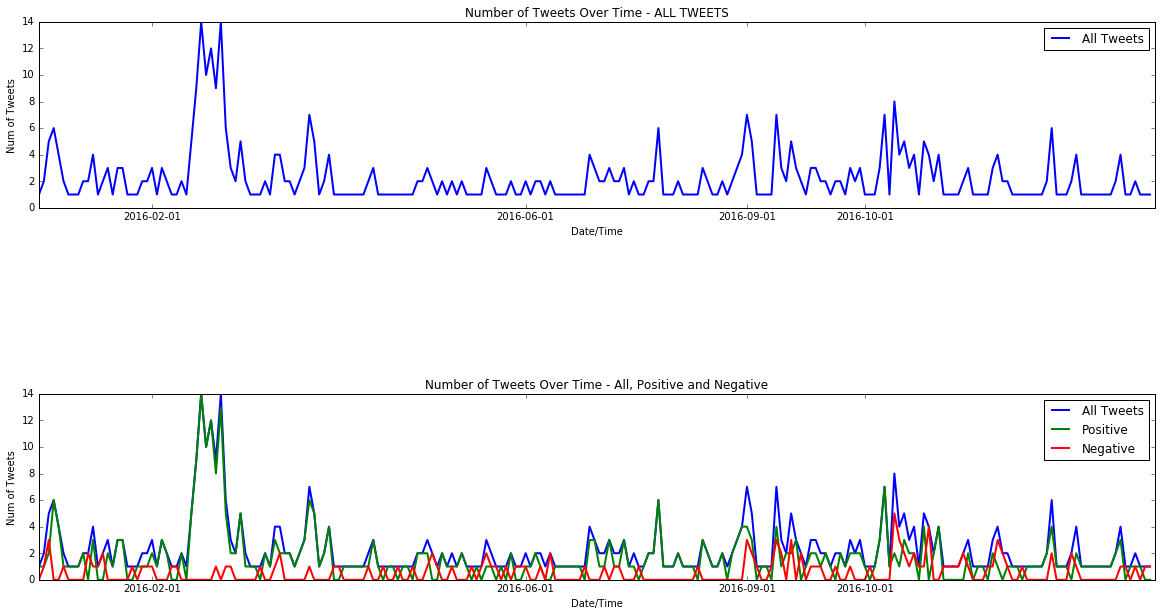

In [20]:
#take the beginning of each month
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']
y = p_df_num_tweets_over_time['NUM_TWEETS']

#positive preparation
py = p_df_num_tweets_and_sentiment_over_time_positive['NUM_TWEETS']
#negative preparation
ny = p_df_num_tweets_and_sentiment_over_time_negative['NUM_TWEETS']
#undefined preparation
ney = p_df_num_tweets_and_sentiment_over_time_neutral['NUM_TWEETS']
#ambivalent preparation
ay = p_df_num_tweets_and_sentiment_over_time_ambivalent['NUM_TWEETS']
#null preparation - undefined
nully = p_df_num_tweets_and_sentiment_over_time_null['NUM_TWEETS']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

#plot1
axes[0].plot(range(len(y)), y, linewidth=2)
axes[0].set_xticks(x.index.tolist())
axes[0].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[0].margins = 0
axes[0].set_xlabel('Date/Time')
axes[0].set_ylabel('Num of Tweets')
axes[0].set_title('Number of Tweets Over Time - ALL TWEETS')
axes[0].set_xlim(0, len(y))
axes[0].legend(loc="upper right", labels=['All Tweets'])
#axes[0].axhline(y=12700, c="red")

axes[1].plot(range(len(y)), y, linewidth=2, color='blue')
axes[1].plot(range(len(py)), py, linewidth=2, color='green')
axes[1].plot(range(len(ny)), ny, linewidth=2, color='red')

axes[1].set_xticks(x.index.tolist())
axes[1].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[1].margins = 0
axes[1].set_xlabel('Date/Time')
axes[1].set_ylabel('Num of Tweets')
axes[1].set_title('Number of Tweets Over Time - All, Positive and Negative')
axes[1].set_xlim(0, len(y))
axes[1].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative', 'Undefined Sentiment'])

fig.subplots_adjust(hspace=1)
plt.show()

In [21]:
# Clear memory
df_num_tweets_and_sentiment_over_time.unpersist()
df_num_tweets_over_time.unpersist()

df_num_tweets_and_sentiment_over_time = None
df_num_tweets_over_time = None

p_df_num_tweets_and_sentiment_over_time = None
#we will need the variable p_df_num_tweets_over_time

p_df_num_tweets_and_sentiment_over_time_positive = None
p_df_num_tweets_and_sentiment_over_time_negative = None
p_df_num_tweets_and_sentiment_over_time_neutral = None
p_df_num_tweets_and_sentiment_over_time_ambivalent = None
p_df_num_tweets_and_sentiment_over_time_null = None

## 8. Drawing insights from tweets about elc manufacturers

This section combines different types of analyses to dig deeper into the list of elc manufacturers . The purpse of the analyses is to obtain elc manufacturer-based insights from tweets that could be interesting and useful to detect potential elc buyers. 

The first step is to detect the tweets that mention certain elc manufacturers. Run the next cell to munge the data into a new data frame that has additional columns for each elc manufacturer. The value in this column in each row indicates whether the elc company was mentioned in a tweet or not. 

This new data frame is the new data source for subsequent computations in this section.

In [22]:
def hasWord(message, word):
    return (word in message)

def checkElcMaker(message):
    tmp = []
    for elc_maker_list_var in elc_makers_list:
        contain = False
        for elc_maker in elc_maker_list_var:
            if (hasWord(message, elc_maker)):
                contain = True
        tmp.extend([contain])
    return tmp

def checkElcFeatures(message, feature_list):
    tmp = []    
    contain = False
    for term in feature_list:
        if (hasWord(message, term.decode('utf8'))):
            contain = True
    tmp.extend([contain])
    return tmp

def getInfluence(tweet):
    return ((tweet.USER_FOLLOWERS_COUNT + tweet.USER_FRIENDS_COUNT) / 2)

def getAllAttributes(tweet):
    message = unicode(tweet.MESSAGE_BODY).lower()
    
    #message id and line
    tmp = [tweet.MESSAGE_ID, tweet.MESSAGE_BODY, tweet.SENTIMENT, tweet.USER_GENDER, unicode(tweet.USER_COUNTRY).upper()\
               , tweet.POSTING_TIME, getInfluence(tweet)]

    #competitors in line
    tmp.extend(checkElcMaker(message))
    
    
    return tmp

columns_names = ['MESSAGE_ID', 'MESSAGE_BODY', 'SENTIMENT', 'USER_GENDER', 'USER_COUNTRY', 'POSTING_TIME', 'INFLUENCE']
for elcMakerName in elc_makers_name_list:
        columns_names.append(elcMakerName)

df_tweets_elc_maker = sqlContext.createDataFrame(df_cleaned_tweets
                             .map(lambda x: getAllAttributes(x)), columns_names)

df_tweets_elc_maker.cache()
df_tweets_elc_maker.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- INFLUENCE: double (nullable = true)
 |-- SAMSUNG: boolean (nullable = true)
 |-- LG: boolean (nullable = true)
 |-- TOSHIBA: boolean (nullable = true)
 |-- PHILIPS: boolean (nullable = true)
 |-- PANASONIC: boolean (nullable = true)



## Analyzing Twitter timelines


You will plot the data over time according to each elc manufacturer. This can be done by using the Spark data frame that you just constructed. You will filter the data by each elc maker and then regroup the resulting data frame according to the posting time of the tweets.

In [23]:
print 'Calculating the number of tweets over 2016 for each maker:'

elc_maker_results_list = []
for elc_maker in elc_makers_name_list:
    #get competitor dataframe
    df_elc_maker = df_tweets_elc_maker.filter(df_tweets_elc_maker[elc_maker] == True)
    overall_elc_maker_time_data = df_elc_maker.groupBy('POSTING_TIME')\
                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                        .orderBy('POSTING_TIME' , ascending=True)

    p_overall_elc_maker_time_data = overall_elc_maker_time_data.toPandas()
    elc_maker_results_list.append(p_overall_elc_maker_time_data)
    
    overall_elc_maker_time_data.unpersist()
    print 'Done for ' + elc_maker

Calculating the number of tweets over 2016 for each maker:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


The plot shows the distribution of tweets about samsun, LGm Toshiba, Philips, Panasonic in 2016 based on the tweet posting dates.

## Discover insight explaining the peak of tweets for Samsung between September 15 and October 15 2016

In [25]:
df_tweets_debacle = df_tweets_elc_maker.filter((df_tweets_elc_maker["SAMSUNG"] == True) &\
                   (df_tweets_elc_maker.POSTING_TIME > '2016-09-15 0.0.0') & \
                   (df_tweets_elc_maker.POSTING_TIME < '2016-10-15 0.0.0'))
df_tweets_debacle.count()

47

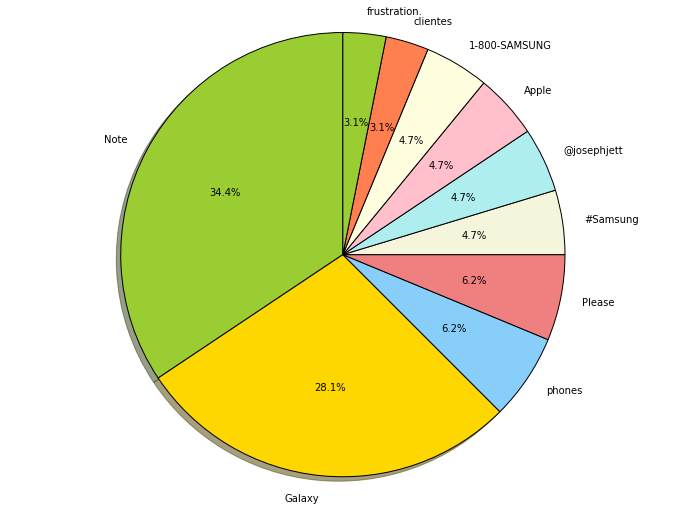

In [26]:
# present a pie chart of the top 10 terms in tweets during the spike in chatter:
from operator import add
import re
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords.extend(["Samsung","de","el","que","en"])
tagsRDD = df_tweets_debacle.flatMap( lambda t: re.split("\s", t.MESSAGE_BODY))\
    .filter( lambda word: not word.startswith("http") and all(ord(c) < 128 for c in word) and word not in cachedStopWords and len(word)>3)\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [27]:
elc_maker_results_list = []

## Adding sentiment analysis

Next extend your analysis and plot results that combine posting time and sentiment change in tweets in 2015. 
Any positive or negative peaks correspond to events that occurred in the elc company at a certain time.

In [29]:
print 'Calculating the number of positive and negative tweets over 2016 for each maker:'

elc_maker_results_list = []
for elc_maker in elc_makers_name_list:
    #get competitor dataframe
    df_elc_maker = df_tweets_elc_maker.filter(df_tweets_elc_maker[elc_maker] == True)
    
    time_sentiment_elc_maker_data = df_elc_maker.groupBy('POSTING_TIME', 'SENTIMENT')\
                                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                        .orderBy('POSTING_TIME', ascending=True)
    
    time_sentiment_elc_maker_data.cache()
    
    time_positive_sentiment_elc_maker_data = time_sentiment_elc_maker_data.filter(time_sentiment_elc_maker_data['SENTIMENT'] == 'POSITIVE')
    time_negative_sentiment_elc_maker_data = time_sentiment_elc_maker_data.filter(time_sentiment_elc_maker_data['SENTIMENT'] == 'NEGATIVE')

    p_time_positive_sentiment_elc_maker_data = time_positive_sentiment_elc_maker_data.toPandas()
    p_time_negative_sentiment_elc_maker_data = time_negative_sentiment_elc_maker_data.toPandas()
    
    #collect results
    elc_maker_results_list.append([p_time_positive_sentiment_elc_maker_data, p_time_negative_sentiment_elc_maker_data])
    time_sentiment_elc_maker_data.unpersist()
    print 'Done for ' + elc_maker

Calculating the number of positive and negative tweets over 2016 for each maker:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


/usr/local/src/bluemix_jupyter_bundle.v44/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


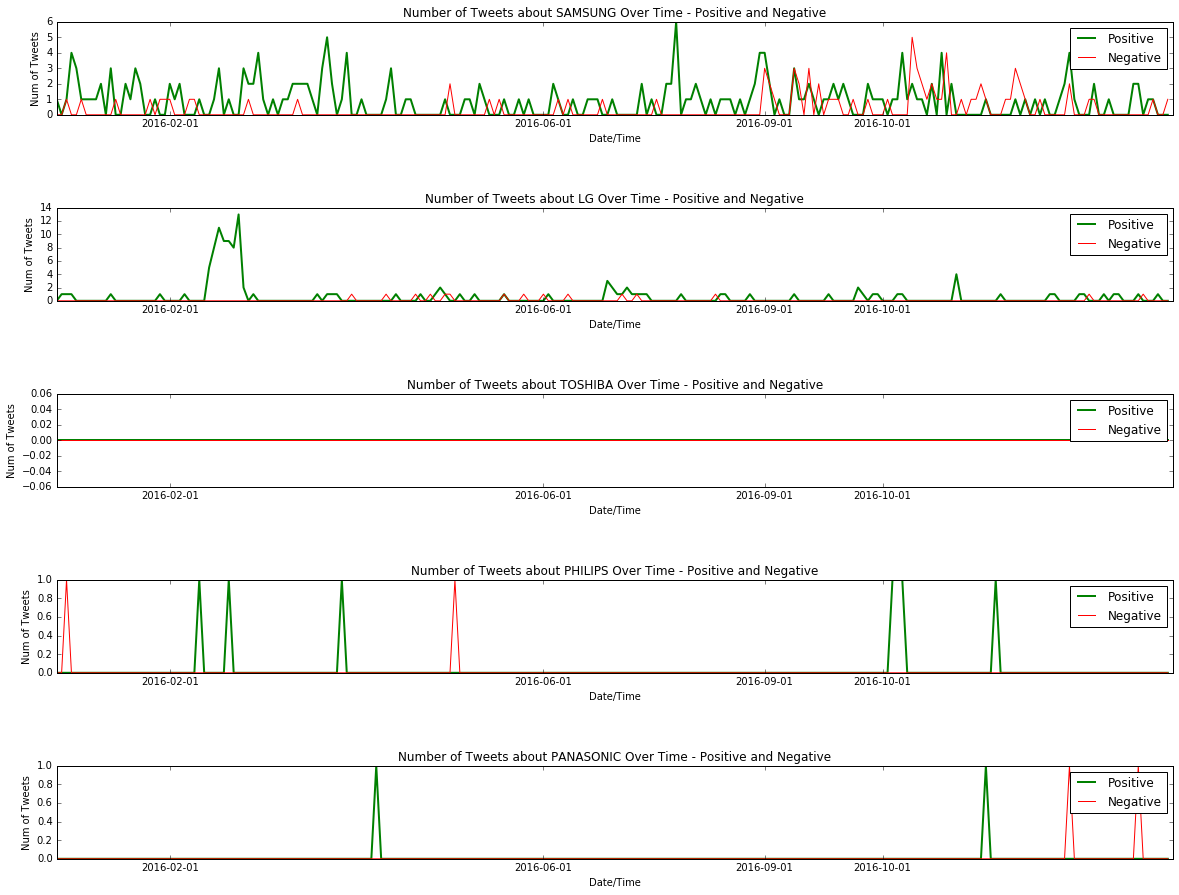

In [48]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']

for i in range(0, len(elc_makers_name_list)):
    elc_maker_results_list[i][0] = addMissingDates(p_df_num_tweets_over_time, elc_maker_results_list[i][0])
    elc_maker_results_list[i][1] = addMissingDates(p_df_num_tweets_over_time, elc_maker_results_list[i][1])

fig, axes = plt.subplots(nrows=len(elc_maker_results_list), ncols=1, figsize=(20, 15))
colors = ['blue', 'red', 'green', 'yellow', 'black']

for i in range(0, len(elc_makers_name_list)):
    y1 = elc_maker_results_list[i][0]['COUNT']
    y2 = elc_maker_results_list[i][1]['COUNT']
    
    axes[i].plot(range(len(y1)), y1, linewidth=2, color='green')
    axes[i].plot(range(len(y2)), y2, linewidth=1, color='red')
    axes[i].set_xticks(x.index.tolist())
    axes[i].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
    axes[i].margins = 0
    axes[i].set_xlabel('Date/Time')
    axes[i].set_ylabel('Num of Tweets')
    axes[i].set_title('Number of Tweets about ' + elc_makers_name_list[i] + ' Over Time - Positive and Negative')
    axes[i].set_xlim(0, len(elc_maker_results_list[0][0]))
    axes[i].legend(loc="upper right", labels=['Positive', 'Negative'])

fig.subplots_adjust(hspace=1)
plt.show()

## Calculating the number of tweets across elc manufacturers

The next code cells calculate the number of tweets about certain elc manufacturers and then plot the resulting numbers in a bar chart and as percentages in a pie chart. 

In [36]:
print 'Calculating the number of tweets that mention one of the makers:'

elc_maker_tweets_count = []
for elc_maker in elc_makers_name_list:
    df_elc_maker = df_tweets_elc_maker.filter(df_tweets_elc_maker[elc_maker] == True)
    elc_maker_tweets_count.append(df_elc_maker.count())
    print 'Done for ' + elc_maker

Calculating the number of tweets that mention one of the makers:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


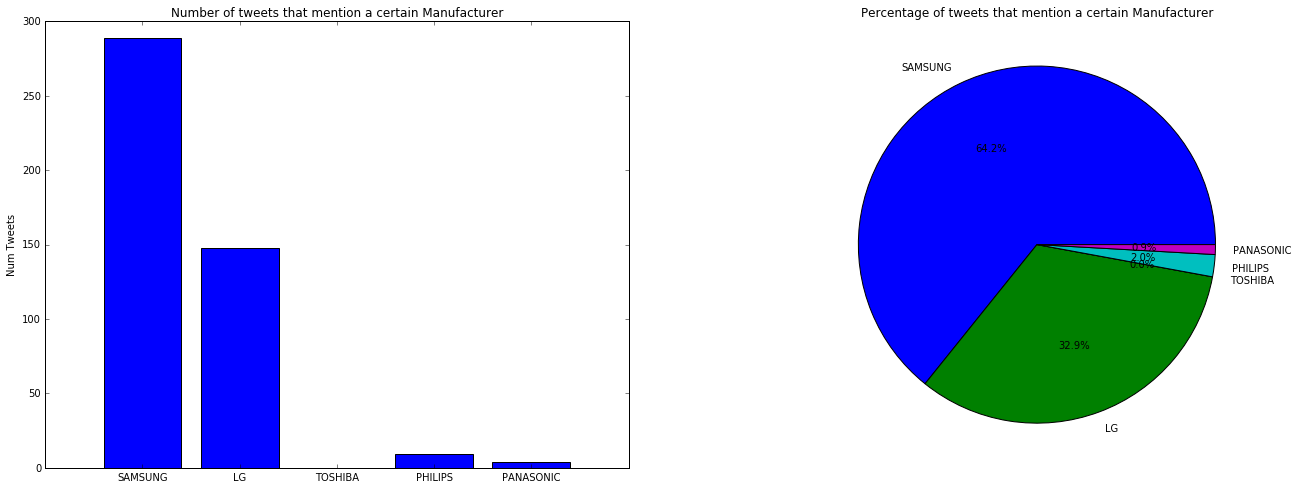

In [37]:
#plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

axes[0].bar(ind, elc_maker_tweets_count, width, color='b', align='center')
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(elc_makers_name_list)

# Plot
axes[1].pie(elc_maker_tweets_count,autopct='%1.1f%%', labels=elc_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of tweets that mention a certain Manufacturer')

fig.subplots_adjust(hspace=1)
plt.show()

# Calculating the distribution of positive and negative tweets

To determine the distribution of sentiment values of the tweets for each manufacturers, run the next cell to calculate the number of positive and negative tweets across  makers and plot the results next to each other.

In [38]:
positive_sum_elc_makers = []
negative_sum_elc_makers = []

for i in range(0, len(elc_makers_name_list)):
    elc_maker = elc_makers_name_list[i]
    elc_maker_results_list[i][0] = elc_maker_results_list[i][0].fillna(0)
    elc_maker_results_list[i][1] = elc_maker_results_list[i][1].fillna(0)
    positive_sum_elc_makers.extend([elc_maker_results_list[i][0]['COUNT'].sum()])
    negative_sum_elc_makers.extend([elc_maker_results_list[i][1]['COUNT'].sum()])

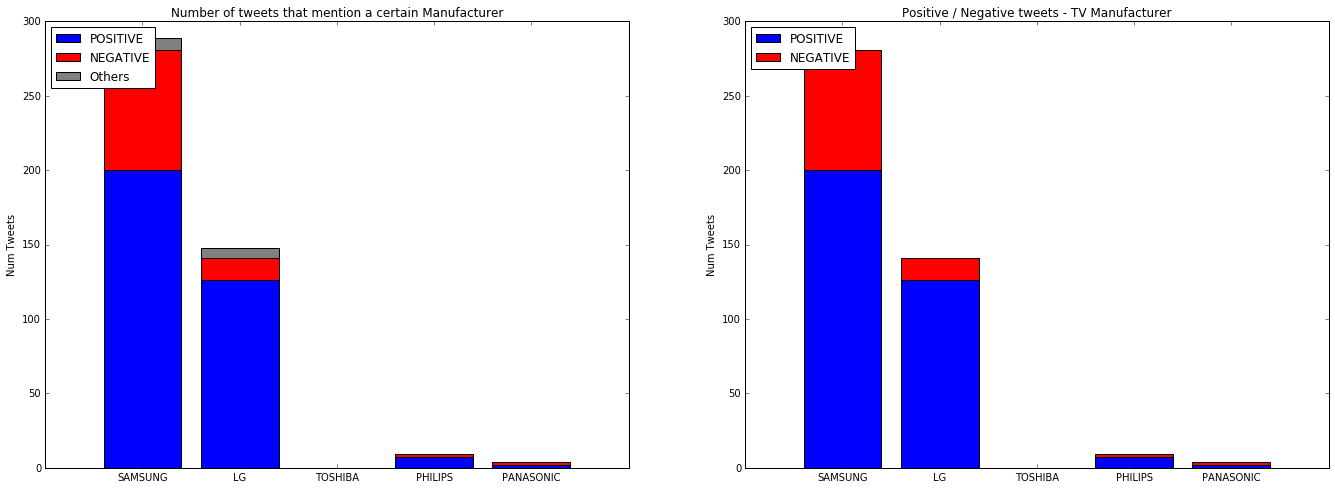

In [39]:
sum_value_P_N = np.add(positive_sum_elc_makers, negative_sum_elc_makers)
competitors_list_rest = np.subtract(elc_maker_tweets_count, sum_value_P_N)

#plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

#axes[0].bar(ind, competitors_list, width, color='b', align='center')
axes[0].bar(ind, positive_sum_elc_makers, width, color='b', align='center')
axes[0].bar(ind, negative_sum_elc_makers, width, color='r', bottom=positive_sum_elc_makers, align='center')
axes[0].bar(ind, competitors_list_rest, width, color='gray', align='center',bottom=sum_value_P_N)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(elc_makers_name_list)
axes[0].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE', 'Others'])

axes[1].bar(ind, positive_sum_elc_makers, width, color='b', align='center')
axes[1].bar(ind, negative_sum_elc_makers, width, color='r', bottom=positive_sum_elc_makers, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Positive / Negative tweets - TV Manufacturer')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(elc_makers_name_list)
axes[1].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE'])

fig.subplots_adjust(hspace=1)
plt.show()

The plots show that in general there are more positive than negative tweets.

## Determining gender distribution 

Another interesting insight when analyzing tweets about certain elc manufacturers and what elc manufacturers might want to pay more attention to for marketing purposes is the distribution of tweets between male and female users. 

The following cells calculate the gender distribution across each competitor and plot the results. 

In [40]:
print 'Calculating the distribution of male and female in tweets over 2016 for each competitors:'

elc_maker_info_list_M_F = []

for elc_maker in elc_makers_name_list:
    df_elc_maker = df_tweets_elc_maker.filter(df_tweets_elc_maker[elc_maker] == True)
    elc_maker_gender_data = df_elc_maker.groupBy('USER_GENDER')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))
    elc_maker_gender_data.cache()

    p_elc_maker_gender_data_male = elc_maker_gender_data.filter(elc_maker_gender_data['USER_GENDER'] == 'male').toPandas()
    p_elc_maker_gender_data_female = elc_maker_gender_data.filter(elc_maker_gender_data['USER_GENDER'] == 'female').toPandas()
    elc_maker_info_list_M_F.append([p_elc_maker_gender_data_male, p_elc_maker_gender_data_female])    
    elc_maker_gender_data.unpersist()
    print 'Done for ' + elc_maker

Calculating the distribution of male and female in tweets over 2016 for each competitors:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


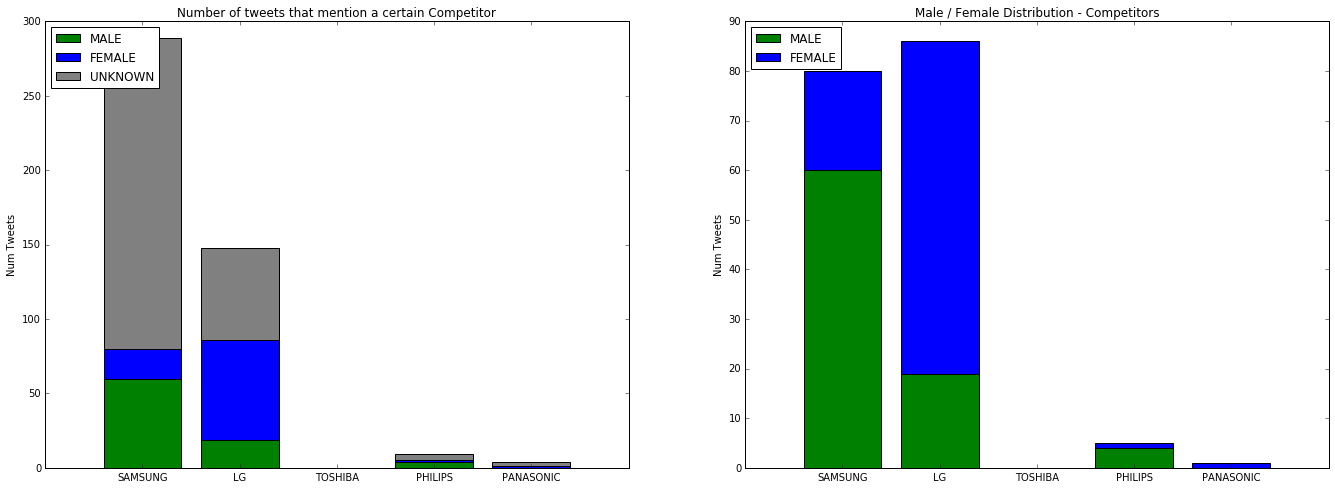

In [41]:
#prepare data for plotting
elc_maker_list_female = []
elc_maker_list_male = []
for i in range(0, len(elc_maker_info_list_M_F)):
    elc_maker_list_female.append(0 if elc_maker_info_list_M_F[i][1]['COUNT'].empty else elc_maker_info_list_M_F[i][1]['COUNT'][0])
    elc_maker_list_male.append(0 if elc_maker_info_list_M_F[i][0]['COUNT'].empty else elc_maker_info_list_M_F[i][0]['COUNT'][0])

sum_value_M_F = np.add(elc_maker_list_male, elc_maker_list_female)
elc_maker_list_M_F_rest = np.subtract(elc_maker_tweets_count, sum_value_M_F)

#plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

axes[0].bar(ind, elc_maker_list_male, width, color='g', align='center')
axes[0].bar(ind, elc_maker_list_female, width, color='b',bottom=elc_maker_list_male, align='center')
axes[0].bar(ind, elc_maker_list_M_F_rest, width, color='gray', align='center',bottom=sum_value_M_F)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Competitor')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(elc_makers_name_list)
axes[0].legend(loc="upper left", labels=['MALE', 'FEMALE', 'UNKNOWN'])

axes[1].bar(ind, elc_maker_list_male, width, color='g', align='center')
axes[1].bar(ind, elc_maker_list_female, width, color='b',bottom=elc_maker_list_male, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Male / Female Distribution - Competitors')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(elc_makers_name_list)
axes[1].legend(loc="upper left", labels=['MALE', 'FEMALE'])

fig.subplots_adjust(hspace=1)
plt.show()

It can be seen in the plotted results that in general, men post more tweets about elcs than women do.

## Measuring influence

In this section, we will calculate the average value of the influence variable of the people who tweeted about a certain elc maker. The influence varable is calculated by: 

$$Influence = ( \space num \space of \space followers + \space number \space of \space friends \space ) \div 2$$


The influence score gives an indication whether someone is a famous person or a public figure in society or whether the twitter account is owned by the media or a company. This average value gives an indication about the people who are interested in a certain elc maker.


In [42]:
#returns a list of pandas DFs.
def getInsights_Influence(sparkDF,elc_maker_list):
    print 'Calculating the influence insight of the users in tweets over 2016 for each competitors:'

    elc_maker_result_list = []
    for elc_maker in elc_maker_list:
        df_elc_maker = sparkDF.filter(sparkDF[elc_maker] == True)
        elc_maker_insight_data = df_elc_maker.select(F.avg('INFLUENCE').alias('AVE_INFLUENCE'))
        elc_maker_result_list.append(elc_maker_insight_data.toPandas())
        df_elc_maker.unpersist()
        elc_maker_insight_data.unpersist()
        print 'Done for ' + elc_maker
    return elc_maker_result_list

In [43]:
influenceInsights = getInsights_Influence(df_tweets_elc_maker, elc_makers_name_list)

Calculating the influence insight of the users in tweets over 2016 for each competitors:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


In [44]:
influence_list = []
for i in range(0, len(elc_makers_name_list)):
    influence_list.append(influenceInsights[i]['AVE_INFLUENCE'][0])

In [45]:
influenceInsights = None

## Determining the distribution of tweets by country across elc manufacturer

The next cells calculate in which countries the most tweets were posted about elc manufacturers. This information can support marketing and sales when evaluating potential customers.

In [46]:
print 'Calculating the country distribution of tweets over 2016 for each elc maker:'

elc_maker_info_list_countries = []
i = 0

for elc_maker in elc_makers_name_list:
    df_elc_maker = df_tweets_elc_maker.filter(df_tweets_elc_maker[elc_maker] == True)
    elc_maker_country_data = df_elc_maker.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                .orderBy('COUNT', ascending=False)
    elc_maker_country_data.cache()

    p_elc_maker_country_data = elc_maker_country_data.toPandas()
    elc_maker_info_list_countries.append(p_elc_maker_country_data)
    elc_maker_country_data.unpersist()
    print 'Done for ' + elc_maker

Calculating the country distribution of tweets over 2016 for each elc maker:
Done for SAMSUNG
Done for LG
Done for TOSHIBA
Done for PHILIPS
Done for PANASONIC


The plots above show the countries with the highest number of tweets about one elc maker. You can also calculate the distribution of tweets about all of the elc makers for one country and compare countries. Run the following cells to compare these results for the US, UK and Germany.

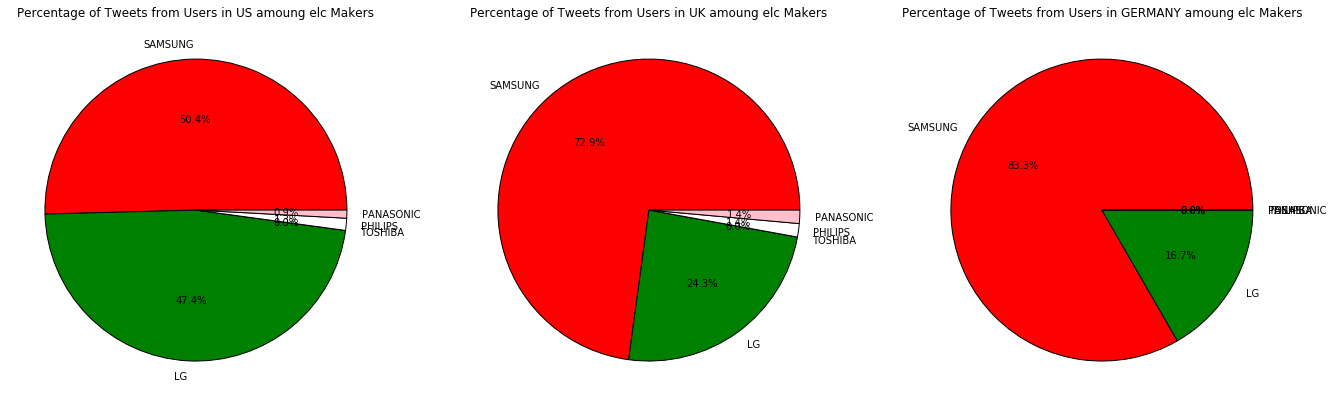

In [47]:
#plot for each country
us_list = []
uk_list = []
de_list = []
def getListForCountry(x, country):
    df=x[x['USER_COUNTRY'] == country]['COUNT']
    return [0] if df.empty else [df.tolist()[0]]    

for i in range(0, len(elc_makers_name_list)):
    x = elc_maker_info_list_countries[i]
    us_list.extend(getListForCountry(x, 'UNITED STATES'))
    uk_list.extend(getListForCountry(x, 'UNITED KINGDOM'))
    de_list.extend(getListForCountry(x, 'GERMANY'))

#plot
colors = ['r', 'g', 'b', 'w', 'pink', 'y']
us_values = us_list
uk_values = uk_list
de_values = de_list

#plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10))

axes[0].pie(us_values,autopct='%1.1f%%', colors=colors, labels=elc_makers_name_list)
axes[0].set_aspect('equal')
axes[0].set_title('Percentage of Tweets from Users in US amoung elc Makers')

# Plot
axes[1].pie(uk_values,autopct='%1.1f%%', colors=colors, labels=elc_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of Tweets from Users in UK amoung elc Makers')

# Plot
axes[2].pie(de_values,autopct='%1.1f%%', colors=colors, labels=elc_makers_name_list)
axes[2].set_aspect('equal')
axes[2].set_title('Percentage of Tweets from Users in GERMANY amoung elc Makers')

fig.subplots_adjust(hspace=1)
plt.show()